In [1]:
IN_PATH = 'data/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

predictors_droped = ['points', 'credit_score']

X_train, X_test, y_train, y_test = pd.read_csv(f'{IN_PATH}X_train.csv'), pd.read_csv(f'{IN_PATH}X_test.csv'), pd.read_csv(f'{IN_PATH}y_train.csv'), pd.read_csv(f'{IN_PATH}y_test.csv')
X_train = X_train.drop(columns=predictors_droped)
X_test = X_test.drop(columns=predictors_droped)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

clf = GaussianNB() # Has parameters var_smoothing=1e-09 by default
clf.fit(X_train, y_train.values.ravel())
y_pred = pd.Series(clf.predict(X_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[159  65]
 [ 94  82]]

Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.71      0.67       224
        True       0.56      0.47      0.51       176

    accuracy                           0.60       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.60      0.60      0.60       400



In [2]:

mean_features_y1 = clf.theta_[0]
mean_features_y2 = clf.theta_[1]

var_features_y1 = clf.var_[0]
var_features_y2 = clf.var_[1]

print(clf.theta_.shape)
print("Mean feature values for class 1:")
print(mean_features_y1)
print("\nMean feature values for class 2:")
print(mean_features_y2)

# Difference in means
mean_diff = (mean_features_y2 - mean_features_y1)
print("\nDifference in mean feature values between class 2 and class 1:")
print(mean_diff)
#print(np.argmax(np.abs(mean_diff)))  # Index of feature with largest difference



(2, 3)
Mean feature values for class 1:
[8.25279565e+04 2.72099175e+04 1.92664437e+01]

Mean feature values for class 2:
[1.00179394e+05 2.25592745e+04 2.20597440e+01]

Difference in mean feature values between class 2 and class 1:
[ 1.76514375e+04 -4.65064297e+03  2.79330025e+00]


GaussianNB()


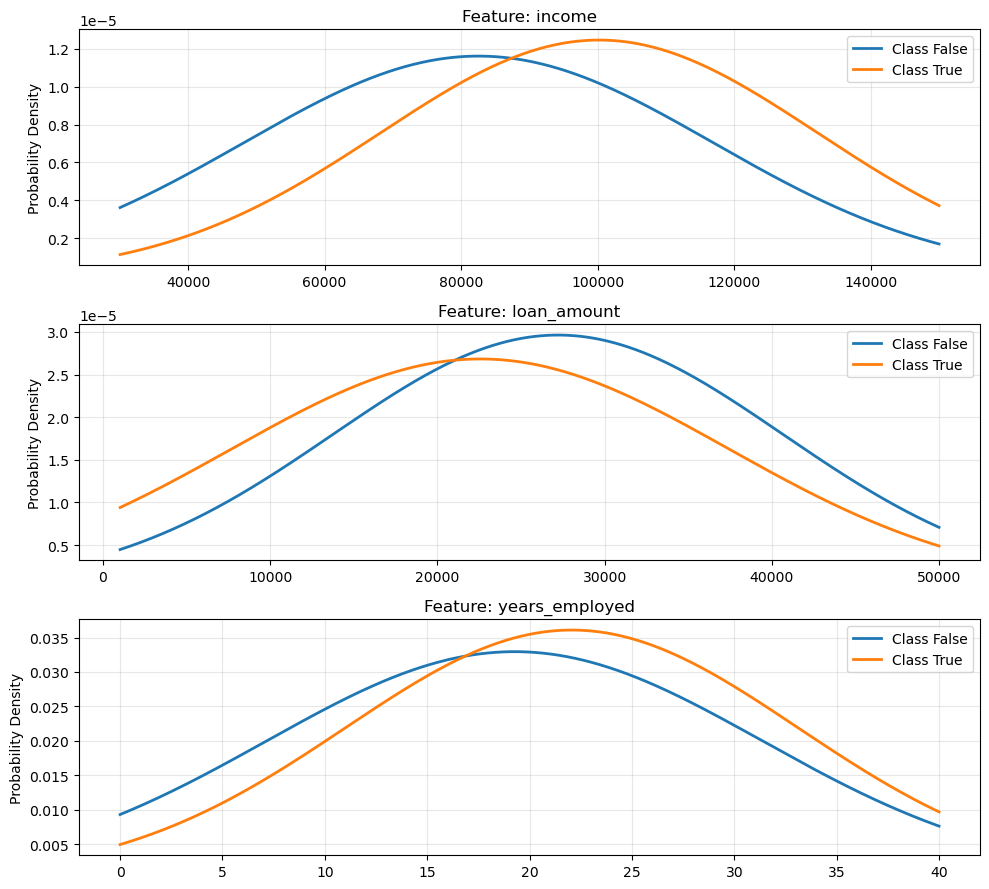

In [3]:
print(clf)
clf.get_params()


from scipy.stats import norm

def plot_feature_posteriors(clf, feature_names, n_features_to_plot=6):
    """

    Plot posterior probability distributions for features
    
    Parameters:
    clf: Your fitted GaussianNB classifier
    feature_names: List of feature names
    n_features_to_plot: Number of features to display (default: first 6)
    """
    n_classes = len(clf.classes_)
    n_features = min(n_features_to_plot, len(feature_names))
    
    # Create subplots
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 3*n_features))
    if n_features == 1:
        axes = [axes]
    
    # Get training data for reference ranges
    X_combined = np.vstack([X_train, X_test])
    
    for i, (ax, feature_idx) in enumerate(zip(axes, range(n_features))):
        # Create range of values for this feature
        feature_min = X_combined[:, feature_idx].min()
        feature_max = X_combined[:, feature_idx].max()
        x_range = np.linspace(feature_min, feature_max, 1000)
        
        # Plot probability density for each class
        for class_idx, class_label in enumerate(clf.classes_):
            mean = clf.theta_[class_idx, feature_idx]
            std = np.sqrt(clf.var_[class_idx, feature_idx])
            pdf = norm.pdf(x_range, mean, std)
            ax.plot(x_range, pdf, 
                   label=f'Class {class_label}', 
                   linewidth=2)
        
        ax.set_title(f'Feature: {feature_names[feature_idx]}')
        ax.set_ylabel('Probability Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Get feature names (assuming your DataFrame has column names)
feature_names = X_train.columns.tolist()

# Plot the posterior distributions
plot_feature_posteriors(clf, feature_names)


/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/martin/mambaforge/envs/work/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


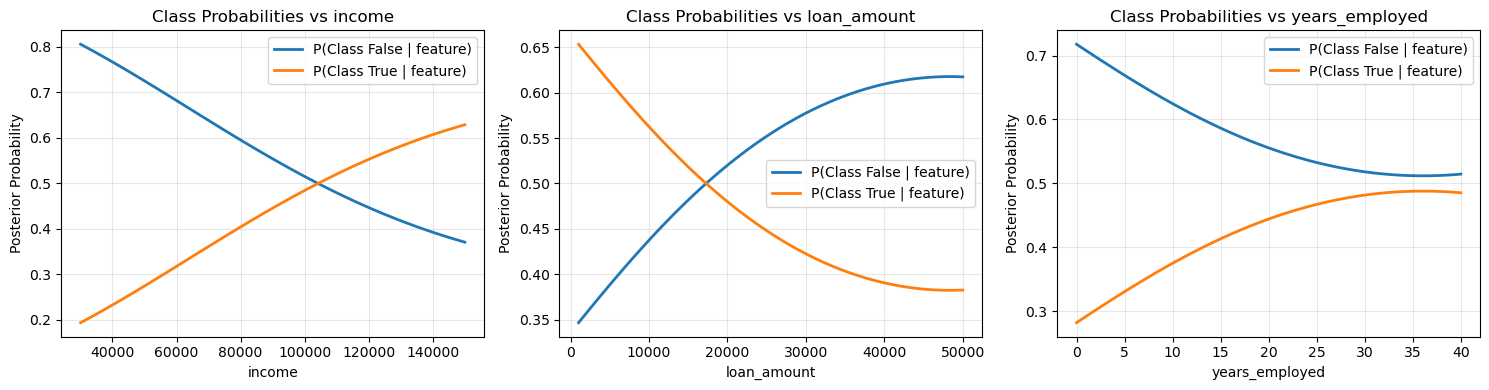

In [4]:
def plot_class_posteriors_by_feature(clf, feature_names, n_features=6):
    """
    Plot how posterior probabilities change with individual feature values
    """
    n_features = min(n_features, len(feature_names))

    n_classes = len(clf.classes_)
    fig, axes = plt.subplots(1, n_features, figsize=(15, 4))
    
    if n_features == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i >= len(feature_names):
            break
            
        # Create test values for this feature (keeping others at mean)
        feature_min = X_train.iloc[:, i].min()
        feature_max = X_train.iloc[:, i].max()
        x_range = np.linspace(feature_min, feature_max, 100)
        
        # Create test points
        X_test_single = np.tile(X_train.mean(axis=0), (100, 1))
        X_test_single[:, i] = x_range
        
        # Predict probabilities
        probas = clf.predict_proba(X_test_single)
        
        # Plot posterior probabilities for each class
        for class_idx in range(n_classes):
            ax.plot(x_range, probas[:, class_idx], 
                   label=f'P(Class {clf.classes_[class_idx]} | feature)',
                   linewidth=2)
        
        ax.set_xlabel(f'{feature_names[i]}')
        ax.set_ylabel('Posterior Probability')
        ax.set_title(f'Class Probabilities vs {feature_names[i]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot class posteriors
plot_class_posteriors_by_feature(clf, feature_names)

In [5]:
def print_parameters(clf, feature_names):
    """
    Print the learned parameters for each feature and class
    """
    print("Learned Parameters for Gaussian Naive Bayes:")
    print("=" * 50)
    
    for class_idx, class_label in enumerate(clf.classes_):
        print(f"\nClass {class_label}:")
        print(f"Prior probability: {clf.class_prior_[class_idx]:.4f}")
        for feature_idx, feature_name in enumerate(feature_names):
            mean = clf.theta_[class_idx, feature_idx]
            std = np.sqrt(clf.var_[class_idx, feature_idx])
            print(f"  {feature_name}: μ = {mean:.3f}, σ = {std:.3f}")

# Print parameters
print_parameters(clf, feature_names)

Learned Parameters for Gaussian Naive Bayes:

Class False:
Prior probability: 0.5606
  income: μ = 82527.957, σ = 34339.648
  loan_amount: μ = 27209.918, σ = 13461.882
  years_employed: μ = 19.266, σ = 12.108

Class True:
Prior probability: 0.4394
  income: μ = 100179.394, σ = 32005.074
  loan_amount: μ = 22559.275, σ = 14869.246
  years_employed: μ = 22.060, σ = 11.055


In [6]:

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#cm = plt.cm.RdBu
#cm_bright = ListedColormap(["#FF0000", "#0000FF"])
#DecisionBoundaryDisplay.from_estimator(
#            clf, X[['income','loan_amount']], cmap=cm, alpha=0.8, eps=0.5
#        )

In [7]:
X_test

,income,loan_amount,years_employed
0,42196,34947,32
1,81876,22682,22
2,103563,28722,35
3,65509,46545,4
4,107110,9947,12
...,...,...,...
395,135518,39434,35
396,139168,9351,16
397,83424,17117,20
398,111973,29812,7


In [8]:

datasets = [(X_train[['income','loan_amount']].values, y_train.values.ravel(),X_test[['income','loan_amount']].values, y_test.values.ravel()),
            (X_train[['income','years_employed']].values, y_train.values.ravel(),X_test[['income','years_employed']].values, y_test.values.ravel()),
            (X_train[['loan_amount','years_employed']].values, y_train.values.ravel(),X_test[['loan_amount','years_employed']].values, y_test.values.ravel())
              ]
names = ['NB - Income vs Loan Amount',
         'NB - Income vs years_employed',
         'NB - Loan Amount vs years_employed']

classifiers = [
    GaussianNB()
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    #X_train, X_test, y_train, y_test = train_test_split(
    #    X, y, test_size=0.4, random_state=42
    #)
    X_train, y_train, X_test, y_test = ds

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()



InvalidIndexError: (slice(None, None, None), 0)

<Figure size 2700x900 with 0 Axes>

In [ ]:

X

array([[ 48449,   4462],
       [ 83528,  32057],
       [133341,   7578],
       ...,
       [103579,   2194],
       [ 73404,   3168],
       [ 98765,  45926]])